# Convolutional Neural Network: VGG-16

In [1]:
import sys
import numpy as np
import tensorflow as tf

Below, we create several helper functions to create the layers of our convolutional neural network:   
    
`conv` takes as its arguments the input volume, the number of filters in the convolutional layer, and a name we assign it. Since we are using pre-trained weights we use the `tf.constant_initializer()`, but when starting from scratch you will want to use `tf.truncated_normal()` or the `xavier_initializer()`. We return the (normalized) output volume, which willl be the input volume to the next layer.

In [2]:
def conv(inputs, n_filters, name):
    weights, bias, beta, gamma, mov_mean, mov_var = load_weights(name)
    with tf.variable_scope(name):
        W = tf.get_variable('W', initializer=weights)
        b = tf.get_variable('b', initializer=bias)
        convolved = tf.nn.conv2d(input=inputs,
                                 filter=W,
                                 strides=[1,1,1,1],
                                 padding='SAME')
        activations = tf.nn.relu(convolved + b)
        normed = tf.nn.batch_normalization(activations, mov_mean, mov_var, beta, gamma, 1e-7)
        return normed

`pool` creates a pooling layer - you will notice that a pooling layer does not have any learned parameters!

In [3]:
def pool(inputs, name):
    with tf.variable_scope(name):
        return tf.nn.max_pool(inputs, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

`fc` creates a fully connected layer as we did before - we compute the weighted sum of pixels, add a bias term, pass the scores through an activation function (we use ReLU), and then normalize the output. 

In [4]:
def fc(inputs, name):
    weights, bias, beta, gamma, mov_mean, mov_var = load_weights(name)
    with tf.variable_scope(name):
        W = tf.get_variable('W', initializer=weights)
        b = tf.get_variable('b', initializer=bias)
        activations = tf.nn.relu(tf.matmul(inputs, W) + b)
        normed = tf.nn.batch_normalization(activations, mov_mean, mov_var, beta, gamma, 1e-7)
        return normed

`softmax` creates a softmax layer, which allows us to convert scores into easily interpretable probabilities. Note that we will only ever use the softmax layer at the very end!

In [5]:
def softmax(inputs, name):
    weights, bias = load_weights(name)
    with tf.variable_scope(name):
        W = tf.get_variable('W', initializer=weights)
        b = tf.get_variable('b', initializer=bias)
        return tf.nn.softmax(tf.matmul(inputs, W) + b)

In [6]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
COLOR_CHANNELS = 3

Our pre-trained weights have been saved as a .npz file, which can be loaded using the `np.load` function - this returns a dict similar to what we get with the CIFAR-10 data. Once we have loaded the weights, we use a helper function to return the appropriate weights given a layer name. For each layer, we have a `kernel` ($W$), `bias` ($b$), and normalization parameters $\beta, \gamma$, the moving average and the moving variance.

In [7]:
WEIGHTS = 'cifar10vgg_numpy.npz'
weights = np.load(WEIGHTS)

In [8]:
def load_weights(layer_name):
    layer_type = layer_name.split('_')[0]
    layer_num = int(layer_name.split('_')[1])
    W = weights["b'" + str(layer_name) + "/kernel:0'"]
    b = weights["b'" + str(layer_name) + "/bias:0'"]
    if layer_type == 'conv2d':
        beta = weights["b'batch_normalization_" + str(layer_num) + "/beta:0'"]
        gamma = weights["b'batch_normalization_" + str(layer_num) + "/gamma:0'"]
        mov_mean = weights["b'batch_normalization_" + str(layer_num) + "/moving_mean:0'"]
        mov_var = weights["b'batch_normalization_" + str(layer_num) + "/moving_variance:0'"]
        return W, b, beta, gamma, mov_mean, mov_var
    elif layer_type == 'dense':
        if layer_num == 1:
            beta = weights["b'batch_normalization_14/beta:0'"]
            gamma = weights["b'batch_normalization_14/gamma:0'"]
            mov_mean = weights["b'batch_normalization_14/moving_mean:0'"]
            mov_var = weights["b'batch_normalization_14/moving_variance:0'"]
            return W, b, beta, gamma, mov_mean, mov_var
        else:
            return W, b

Here we set up the architecture of our convolutional network, as in the diagram below (with a slight modification of the fully connected layers):     
![alt text](vgg16.png "Title")

In [9]:
img = tf.placeholder(tf.float32, shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS], name='img')

conv1_1 = conv(img, 64, 'conv2d_1')
conv1_2 = conv(conv1_1, 64, 'conv2d_2')
pool1 = pool(conv1_2, 'pool1')

conv2_1 = conv(pool1, 128, 'conv2d_3')
conv2_2 = conv(conv2_1, 128, 'conv2d_4')
pool2 = pool(conv2_2, 'pool2')

conv3_1 = conv(pool2, 256, 'conv2d_5')
conv3_2 = conv(conv3_1, 256, 'conv2d_6')
conv3_3 = conv(conv3_2, 256, 'conv2d_7')
pool3 = pool(conv3_3, 'pool3')

conv4_1 = conv(pool3, 512, 'conv2d_8')
conv4_2 = conv(conv4_1, 512, 'conv2d_9')
conv4_3 = conv(conv4_2, 512, 'conv2d_10')
pool4 = pool(conv4_3, 'pool4')

conv5_1 = conv(pool4, 512, 'conv2d_11')
conv5_2 = conv(conv5_1, 512, 'conv2d_12')
conv5_3 = conv(conv5_2, 512, 'conv2d_13')
pool5 = pool(conv5_3, 'pool5')

flattened = tf.reshape(pool5, [-1, 512])
fc6 = fc(flattened, 'dense_1')
pred = softmax(fc6, 'dense_2')

As before, we use the a helper function to allow us to load CIFAR-10 data.

In [10]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        if sys.version[0] == '3':
            dict = pickle.load(fo, encoding='bytes')
        elif sys.version[0] == '2':
            dict = pickle.load(fo)
    return dict

The network we are using was trained on standardized data, meaning that all the inputs were scaled so that the mean of the training data was 0 and the standard deviation was 1. This is a technique that allows us to train the model faster, because if we work with strictly positive input values from 0-255, we have a strong bias towards highly positive activations if we randomly initialize our weights.

In [11]:
MEAN = 120.707
STD = 64.15

def normalize(X_test):
    return (X_test - MEAN)/(STD + 1e-7)

def denormalize(X_out):
    return (X_out)*(STD + 1e-7) + MEAN

Let's test the performance of our convolutional network on the CIFAR-10 data we have been using!

In [12]:
cifar10 = unpickle('../cifar-10-data')
permutation = np.random.permutation(10000)
data = np.array(cifar10[b'data'])[permutation]
labels = np.array(cifar10[b'labels'])[permutation]

n_images = 300
x_test = normalize(data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))[:n_images]
y_test = labels[:n_images]

We now create a placeholder to feed in the labels, and define `correct` and `accuracy` so we can analyze the performance of our model.

In [13]:
y = tf.placeholder(tf.int64, [None,], name='y')
correct = tf.equal(tf.argmax(pred, axis=1), y)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [14]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
acc = sess.run(accuracy, feed_dict={img:x_test, y:y_test})

print('Accuracy on CIFAR-10 data: ' +  str(100*round(acc, 4)) + '%')

Accuracy on CIFAR-10 data: 100.0%


While our model is definitely very powerful, this measure is deceiving as the network was trained using this exact data! We can't tell if our model simply "memorized" all the images in the dataset, or if it generalizes to other images as well. Let's now test the model using data that it was not trained on.

In [15]:
cifar10 = unpickle('test_batch')
permutation = np.random.permutation(10000)
data = np.array(cifar10[b'data'])[permutation]
labels = np.array(cifar10[b'labels'])[permutation]

n_images = 300
x_test = normalize(data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8"))[:n_images]
y_test = labels[:n_images]

In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
acc = sess.run(accuracy, feed_dict={img:x_test, y:y_test})

print('Accuracy on CIFAR-10 test data: ' +  str(100*round(acc, 4)) + '%')

Accuracy on CIFAR-10 test data: 94.3300008774%


Accuracy on the testing set is still very high! Convolutional neural networks are the state-of-the-art architecture for image classification. In case you still don't believe these results, we can test on arbitrary images below.

The packages below will be used to load images and plot them.

In [17]:
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline

Below is a helper funtion that will read in a local image file from your computer and create a tensor with dimensions [1, height, width, 3] that can be fed into our CNN.

In [18]:
def load_image(path):
    image = scipy.misc.imread(path)
    image = np.reshape(image, ((1,) + image.shape)) 
    image = normalize(image)                     
    return image

Test your own images by changing the file path `IMG` below. (Note that your images must be 32x32)

In [19]:
label_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
IMG = 'dog-small.jpg'

Prediction: dog


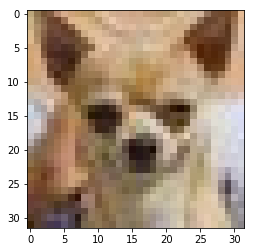

In [20]:
test_image = load_image(IMG)
prediction = np.argmax(sess.run(pred, feed_dict={img:test_image}))

plt.imshow(255 - denormalize(test_image[0]));
print('Prediction:', label_names[prediction])

To further train the network using your own data, you can create a labeled dataset of your own and use the code below!

In [21]:
def scores(inputs, name):
    W, b = load_weights(name)
    W = tf.constant(W)
    b = tf.constant(np.reshape(b, (b.size)))
    return tf.matmul(inputs, W) + b

In [22]:
s = scores(fc6, 'dense_2')
with tf.variable_scope('Optimization'):
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=s))    
    train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss) 

In [23]:
n_epochs = 1000
batch_size= 256

training_size = x_train.shape[0]

for j in range(n_epochs):
    perm = np.random.permutation(training_size) 
    for i in range(0, training_size, batch_size):
        idx = perm[i:i+batch_size]  
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        sess.run(train_step, feed_dict={x:x_batch, y:y_batch})
    if j%50 == 49 or j==0:
        l, r, a = sess.run([loss, regularizer, accuracy], feed_dict={x:x_train, y:y_train})
        print("epoch %6d, loss=%6f, regularizer=%0.4f, accuracy=%.2f%%" % (j+1, l, round(r, 4), 100*round(a, 4)))

NameError: name 'x_train' is not defined